In [1]:
from math import log
from os.path import basename, join

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## How to use this notebook

**Input**: MAG summary statistics table(s) `uhgg.summary.csv` generated by the script `summarize_reports.py`. 

**Output**: 

1) Grouped bar graph(s) of the number of contigs, bases, and mean contig length made be each *de novo* assembler grouped by sample. 

2) Violin plots of all contigs lengths for each *de novo* assembler grouped by sample. 

### Steps

**Usage**: There are four cells that require user customization, described below. I designed this notebook specifically for the test dataset but tried to generalize as much as possible. Each of these cells is indicated with the text `Customize here`. 

1) Add paths to the MAG summary statistics tables  you want to visualize to `stats_lst`.

- More summary tables can be added if you want to aggregate reports from several runs!

2) Customize how the samples are named and grouped using `samples_ordered` and `samples_labeled`. 

4) Customize the number of bar colours according to the number of samples using `samples_colours`. 

## Load sample tables

### Contig summary statistics tables

In [2]:
# Set seaborn plotting aesthetics as default
sns.set()

In [3]:
# Customize here
# Add MAG summary statistics tables to a list
stats_lst = ['test_data/test_out/mag_qc/final_reports/uhgg.summary.csv']
out_dir = 'test_data/test_out/dataviz'

# If applicable, rename the samples in the table and/or set display names
samples_ordered = ['uhgg']
samples_labeled = ['UHGG'] # Optional- can also be merged_df['sample_name']

# Set the number of colours equal to the number of samples.
samples_colours = ['#ffa600'] # ['#ffa600', '#ff6361', '#bc5090', '#58508d', '#003f5c']

In [5]:
# Add MAG summary statistics tables for each set of samples to a list
# Merge the dataframes and check their contents
stats_df_lst = []
for s in stats_lst:
    df_lst = []
    tmp_df = pd.read_csv(s, header = 0)
    num_mags = tmp_df.shape[0]
    sample_name = basename(s).split('.')[0]
    tmp_df.insert(0, 'sample_name', [sample_name] * num_mags)
    df_lst.append(tmp_df)
    print('{}: {}'.format(sample_name, tmp_df.shape))
    stats_df_lst.append(pd.concat(df_lst))

# stats_df_lst[-1].iloc[[1,20,40],:] 
stats_df_lst[-1]

uhgg: (4, 20)


,sample_name,mag,completeness,contamination,N50,size,GC,classification,bin_cov,ref_cov,ANI,genome_fraction,NG50,NA50,num_misassemb,prop_misassemb_ctgs,prop_misassemb_len,prop_unaln_ctgs,prop_unaln_len,Quality
0,uhgg,0,93.25,5.00,4934,4495431,0.57,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,94.64,86.59,98.80,86.106,4549,4582,21,0.017171,0.032368,0.049877,0.055317,High quality
1,uhgg,1,85.61,1.70,4341,2541531,0.58,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__O...,97.99,80.95,99.74,79.650,3548,4254,3,0.003686,0.003673,0.017199,0.019925,Medium quality
2,uhgg,2,92.33,8.47,4360,4424510,0.42,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...,75.94,77.14,98.53,72.111,4318,2807,63,0.039749,0.068235,0.228033,0.257660,Medium quality
3,uhgg,3,93.24,4.91,4699,4202362,0.45,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...,81.69,81.13,95.39,58.361,4690,1889,14,0.010590,0.021727,0.423601,0.408548,High quality


In [6]:
# Make classified MAG relative abundance dataframes the same way
# Add MAG summary statistics tables for each sample set to a list
# Merge the sample set dataframes and check their contents
ra_df_lst = []
for s in stats_lst:
    tmp_df = pd.read_csv(s, header = 0)
    sample_name = basename(s).split('.')[0]
    tmp_df.insert(0, 'sample_name', [sample_name] * num_mags)
    tmp_df[sample_name] = tmp_df['bin_cov'] / tmp_df['bin_cov'].sum()
    fin_df = tmp_df[['classification', sample_name]]
    ra_df_lst.append(fin_df)

ra_df = ra_df_lst[0]
for i in range(1, len(ra_df_lst)):
    ra_df = pd.merge(ra_df, ra_df_lst[i], on = ['classification'])

# ra_df.iloc[[1,20,40],:] 
ra_df

,classification,uhgg
0,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,0.270199
1,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__O...,0.279764
2,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...,0.216810
3,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...,0.233227


# Sample-Specific MAG Summary Statistics

## General Quality-Checking Statistics 

In [7]:
# Set names of the 16 QC parameters
parameters = ['completeness','contamination','bin_cov','ANI','GC',\
              'N50','size','genome_fraction','NG50','NA50','prop_misassemb_ctgs',\
              'prop_misassemb_len','prop_unaln_ctgs','prop_unaln_len'] # 'strain_heterogeneity','num_ctgs',
param_names = ['Completeness','Contamination','MAG Coverage (X)',\
               'ANI','GC','N50','MAG Size (bp)','Genome Fraction (%)','NG50','NA50',\
               'Prop. Misassemb. Contigs','Prop. Misassemb. Len. (bp)',\
               'Prop. Unaligned Contigs','Prop. Unaligned Len. (bp)'] # 'Strain Heterogeneity','Num. Contigs',

In [8]:
# Define plotting region for 16 general QC stats
num_rows = 4
num_cols = 4
num_plts = num_rows * num_cols

In [9]:
def box_plot(df, p, n, a):
    p = sns.boxplot(data = df, x = 'sample_name', y = p, palette = samples_colours, ax = a)
    p.set_xticklabels(samples_labeled)
    p.set_xlabel(None)
    p.set_ylabel(n, size = 16) # Set the y-axis label as the parameter only 
    return p

Text(0, 0.5, 'Num. MAGs')

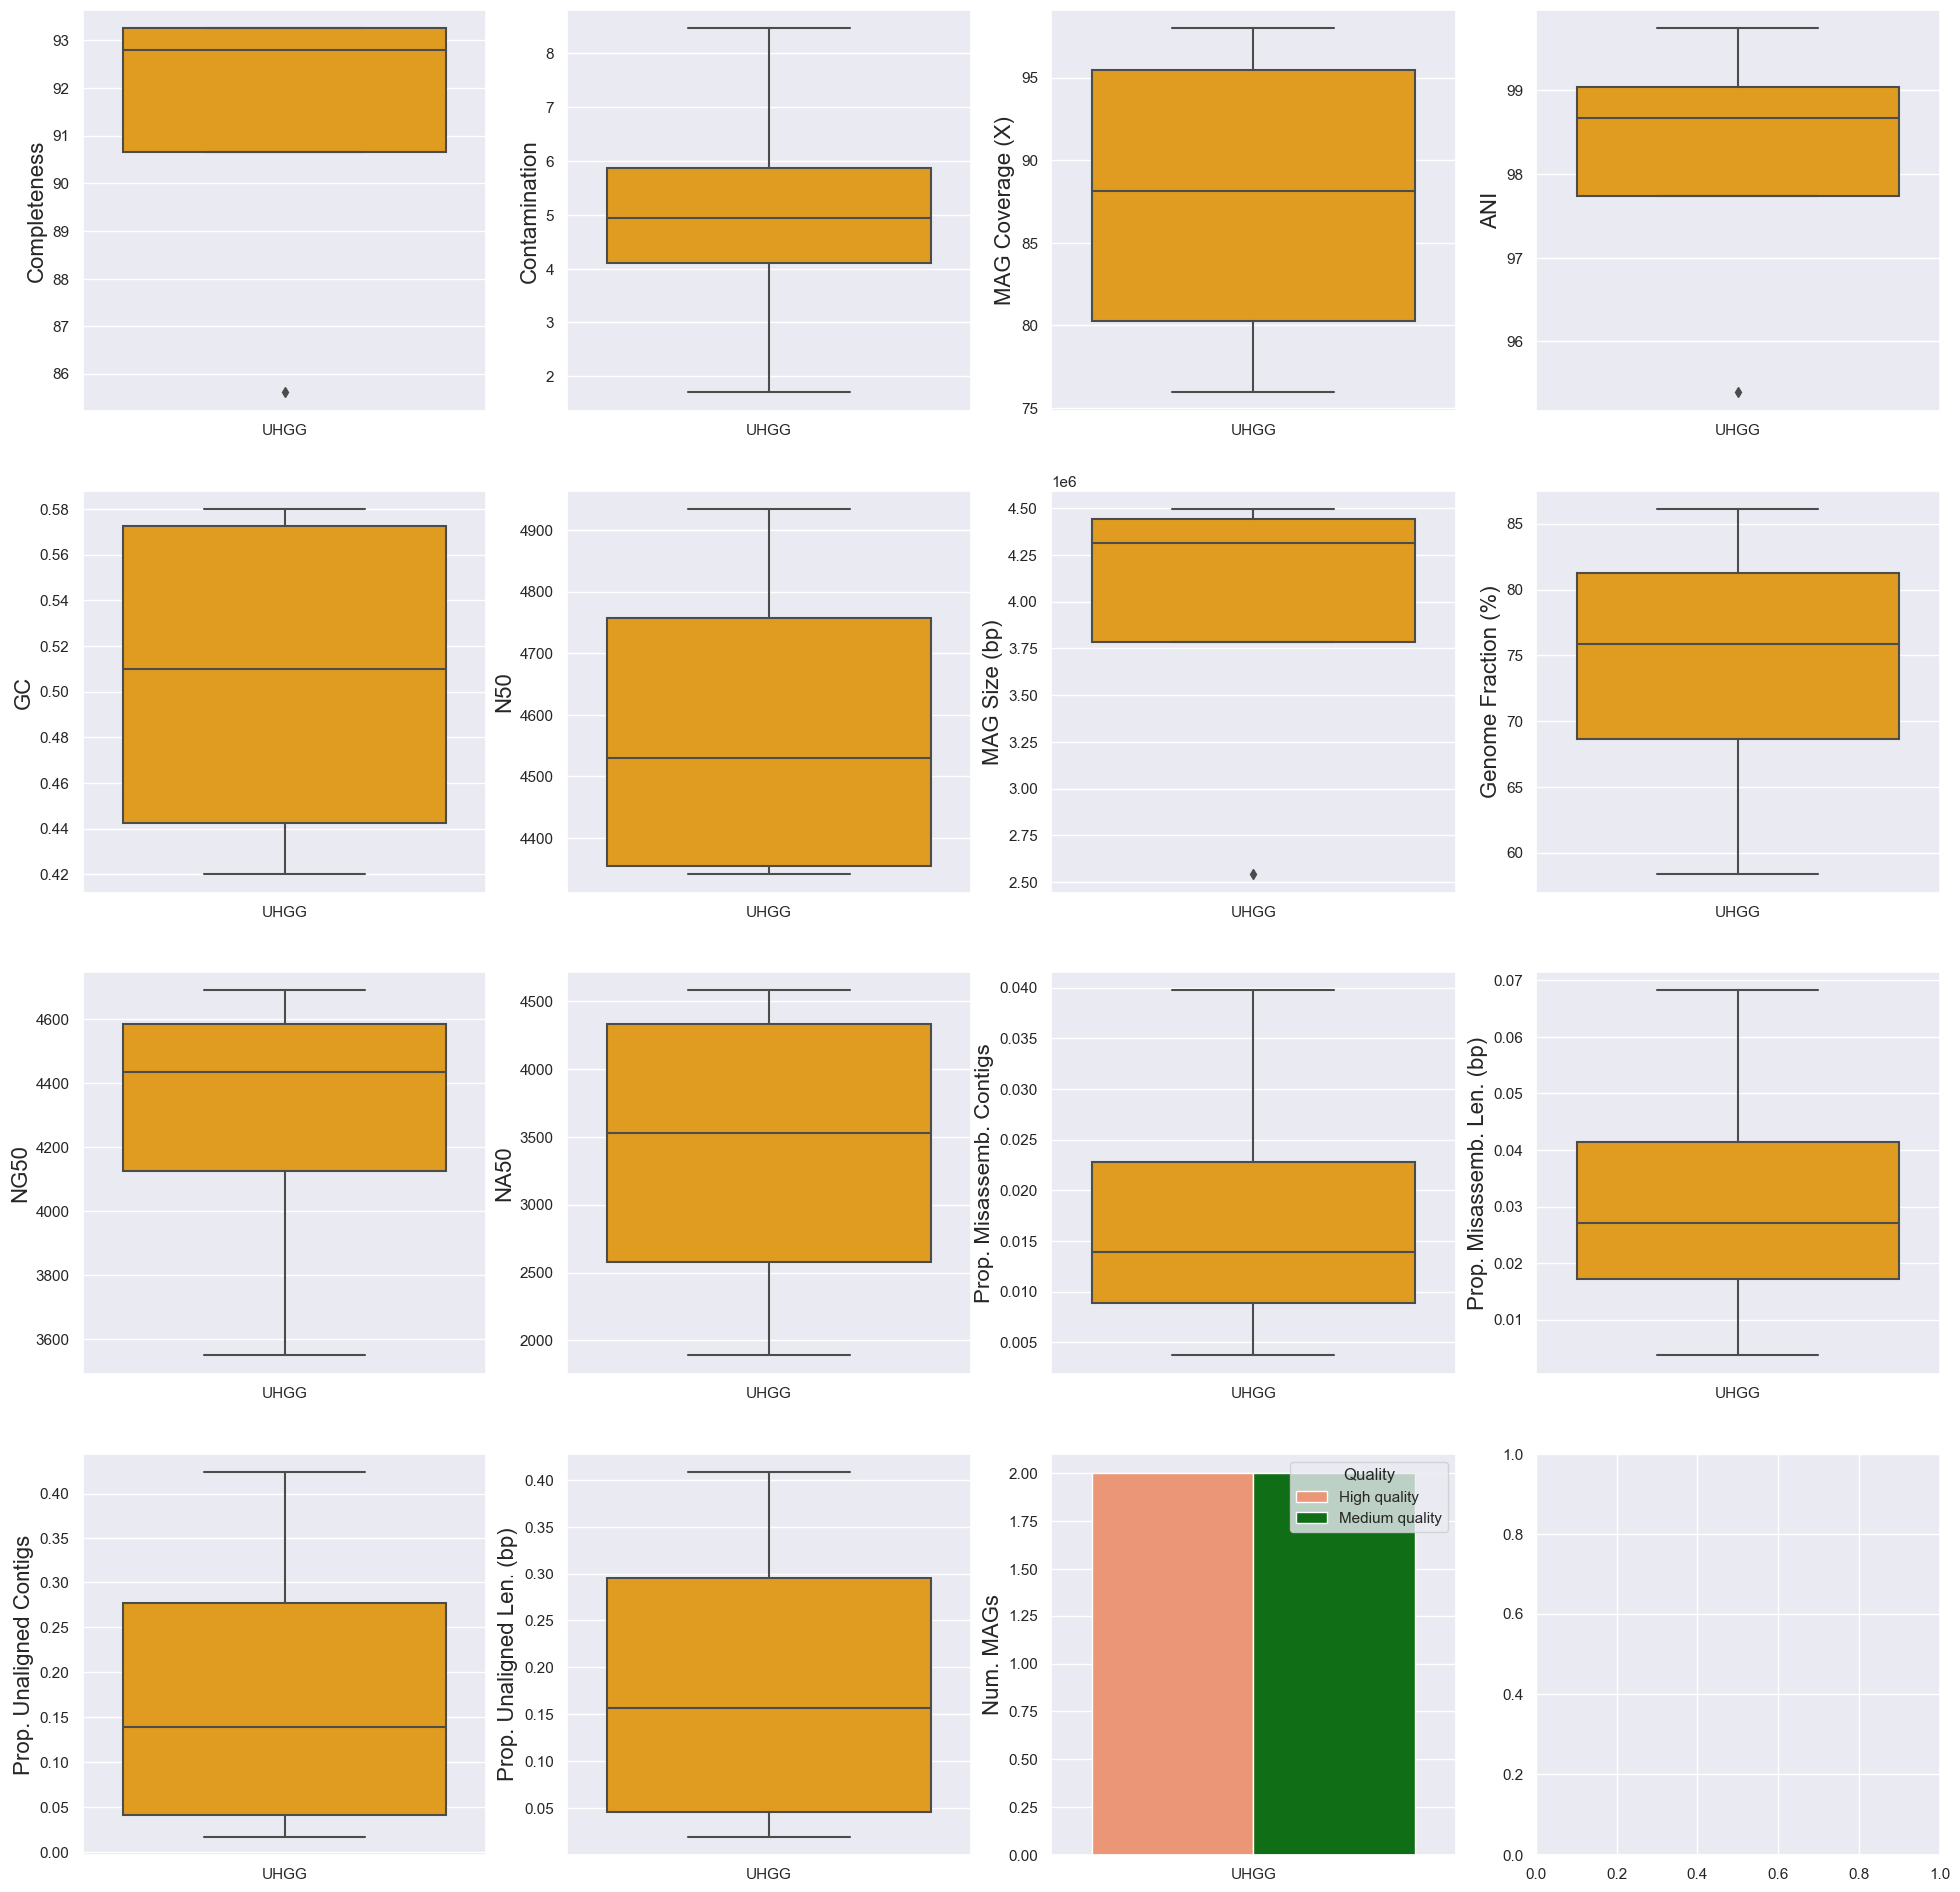

In [10]:
fig, axs = plt.subplots(num_rows, num_cols, figsize = (24,24)) # in.
stats_df = pd.concat(stats_df_lst)
for j, p in enumerate(parameters): # for i, df in enumerate(stats_df_lst):
    row = int(j // num_cols)
    col = int(j % num_cols)
    box_plot(stats_df, p, param_names[j], axs[row,col])

qual_df = stats_df.groupby(['sample_name', 'Quality']).count().reset_index()
p = sns.countplot(data = stats_df, x = 'sample_name', hue = 'Quality', 
        palette = ['#ff8d65', '#007e08'], ax = axs[3,2])
p.set_xticklabels(samples_labeled)
p.set_xlabel(None)
p.set_ylabel('Num. MAGs', size = 16) # Set the y-axis label as the parameter only 

In [12]:
fig.savefig(join(out_dir, 'summary_statistics.svg'), dpi = 1000, bbox_inches = 'tight')

## Read alignment to MAGs vs. classification reference genome

In [20]:
# Define plotting region for dot plot of the proportion of the whole sequence that reads align to
num_rows = 1
num_cols = len(samples_ordered)

In [13]:
def coverage_dot_plot(df):
    p = sns.scatterplot(data = df, x = 'ref_cov', y = 'bin_cov', hue = 'sample_name', palette = samples_colours)
    p.set_xlabel('Reference Cov.', size = 16) 
    p.set_ylabel('MAG Cov.', size = 16) 
    p.legend(labels = samples_labeled)
    return p

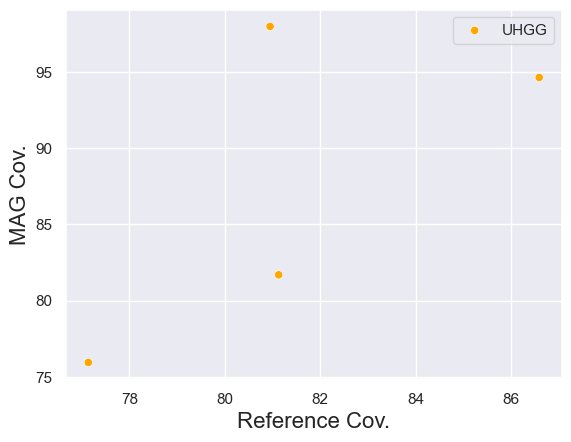

In [14]:
p = coverage_dot_plot(stats_df)

In [15]:
p.get_figure().savefig(join(out_dir, 'mag_ref_cov.svg'), dpi = 1000, bbox_inches = 'tight')

## Classification-based Summary Statistics

In [23]:
# Make a presence-absence dataframe by casting non-zero relative abundances up to 1
pa_df = ra_df.copy()
for s in samples_ordered:
    pa_df[s] = [1 if a > 0 else 0 for a in tmp_df[s]]

# pa_df.iloc[[1,20,40],:]
pa_df

,classification,uhgg
0,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,1
1,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__O...,1
2,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...,1
3,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...,1


In [27]:
# Sum the presence-absences of all taxa for each sample prep and melt the sample columns together for a flatter dataframe
# Can't do this with just one sample so this is for show only
agg_dct = {}
for c in samples_ordered:
    agg_dct[c] = 'sum'

pa_melt_df = pa_df.aggregate(agg_dct)
# pa_melt_df = pd.DataFrame({'sample_name':pa_tmp_df.index, 'Num. Taxa':pa_tmp_df.values})

pa_melt_df

uhgg    4
dtype: int64

In [25]:
def shannon_index(row):
    s_lst = []
    for s in samples_ordered:
        if row[s] == 0:
            s_lst.append(0)
        else:
            s_lst.append(-log(float(row[s]))*float(row[s]))
    return s_lst

In [26]:
# Calculate H for each sample
tmp_lst = list(ra_df.apply(lambda row : shannon_index(row), axis = 1))
h_df = pd.DataFrame(tmp_lst, columns = samples_ordered)
print('{}'.format(h_df.shape))

# h_df.iloc[[1,20,40],:]
h_df

(4, 1)


,uhgg
0,0.353582
1,0.356366
2,0.331445
3,0.339518


In [29]:
# Sum H for each sample prep and melt the sample prep columns together
# Can't do this with just one sample so this is for show only
h_melt_df = h_df.aggregate(agg_dct)
# h_melt_df = pd.DataFrame({'sample_name':h_tmp_df.index, 'Shannon Index':h_tmp_df.values})

h_melt_df

uhgg    1.380911
dtype: float64

### Alpha diversity in each sample preparation

In [30]:
def bar_plot(df, a, stat):
    # stat = pres_abs or shannon
    p = sns.barplot(data = df, x = 'sample_name', y = stat, palette = samples_colours, ax = a)
    p.set_xticklabels(samples_labeled, size = 16) #, rotation = 45, ha = 'right') # Relabel each of the groups
    p.set(xlabel = None, ylabel = stat) 
    return p

In [31]:
%%capture
# To suppress figure output
# Define plotting region (1 row, 2 columns 1 for each diversity metric)
num_rows = 1
num_cols = 2
fig, axs = plt.subplots(num_rows, num_cols, figsize = (24,12)) # in.
alpha_stat = ['Num. Taxa', 'Shannon Index']

In [34]:
# Plot the number of taxa and Shannon entropy from each sample prep
# Can't do this with just one sample so this is for show only
# for i, df in enumerate([pa_melt_df, h_melt_df]):
#      bar_plot(df, axs[i], alpha_stat[i])

In [35]:
fig.savefig(join(out_dir, 'num_shanh.svg'), dpi = 1000, bbox_inches = 'tight')